# LOAD DATA 

In [15]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH =  r'C:\Users\mahan\Desktop\Code\RAVDEES'
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/kaggle/input/',dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 600


,Emotion,Emotion intensity,Gender,Path
0,1,normal,male,C:\Users\mahan\Desktop\Code\RAVDEES\Actor_01\0...
1,1,normal,male,C:\Users\mahan\Desktop\Code\RAVDEES\Actor_01\0...
2,1,normal,male,C:\Users\mahan\Desktop\Code\RAVDEES\Actor_01\0...
3,1,normal,male,C:\Users\mahan\Desktop\Code\RAVDEES\Actor_01\0...
4,2,normal,male,C:\Users\mahan\Desktop\Code\RAVDEES\Actor_01\0...


In [17]:
audio = r'C:\Users\mahan\Desktop\Code\RAVDEES'
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:24]

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10']

Text(0, 0.5, 'Number of examples')

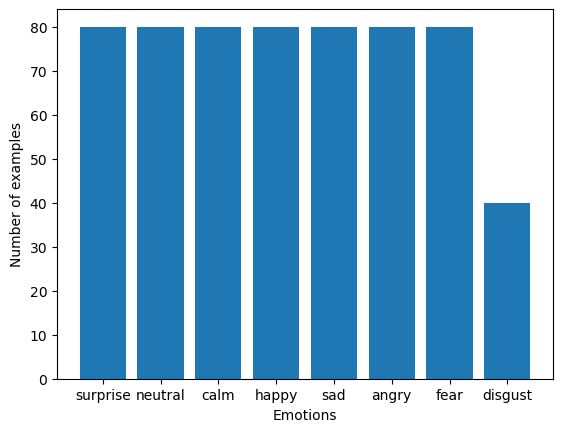

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

number of examples per gender

Text(0, 0.5, 'Number of examples')

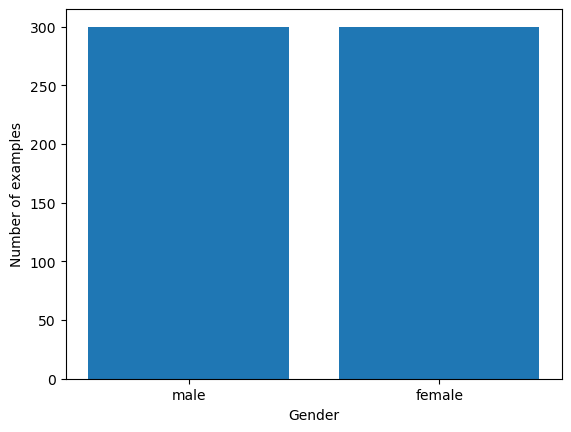

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

number of examples per emotion intensity

Text(0, 0.5, 'Number of examples')

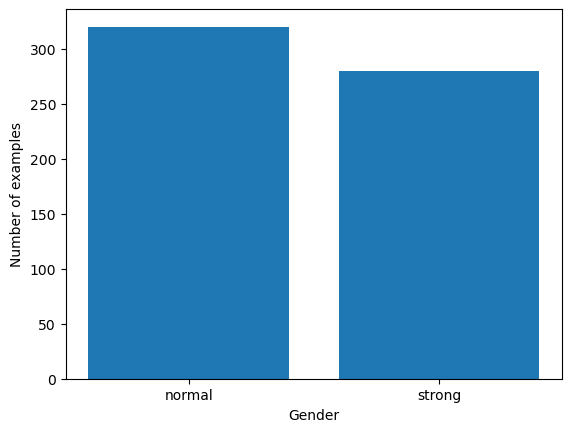

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Emotion intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.signal import stft, fftconvolve, find_peaks
from scipy.io.wavfile import read
import scipy as sp
import librosa.display as ld

In [32]:
xn, sr = librosa.load('OSR_us_000_0030_8k.wav')
xn.shape
sr
ipd.Audio('OSR_us_000_0030_8k.wav')

def dft_custom(xn):
    N = xn.shape[0]
    e_matrix = np.fromfunction(lambda m, n: np.exp(-(2*np.pi*m*n*1j)/N), (N, N))
    return e_matrix.dot(xn)

In [34]:
res = stft(xn, window_size = 500, hopsize = int(500/4))
ld.specshow(librosa.amplitude_to_db(np.abs(res.T), ref=np.max), hop_length=int(500/4),y_axis='linear', x_axis='time')
plt.savefig('stft_fft.png')

def stft(xn, window_size = None, hopsize= 512, window = 'hamming', fft_size = 512):
    total_samples = xn.shape[0]
    
    if window_size == None:
        window_size = fft_size
    
    if hopsize == None:
        hopsize = int(fft_size/4)

    
    # Getting window of size window_size
    window_fn = sp.signal.get_window(window, Nx=fft_size)
    
    start_index = 0 - hopsize
    end_index = window_size - hopsize
    
    stft_res = []
    
    
    counter = 0
    while start_index + hopsize <= total_samples - window_size:
        start_index = start_index + hopsize
        end_index = end_index + hopsize
        
        x_window = xn[start_index:end_index]
        
        
        # x_window is of window_size. Need to pad it to fft_size
        diff = fft_size - window_size
        
        if diff % 2 == 0:

            x_window = np.pad(x_window, (int(diff/2), (int(diff/2))))
            
        else:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2)+1)))
        
        
        try:
        
            mult_window = x_window * window_fn
        
        except:
            print(start_index)
            print(end_index)
                    
        dft_window = dft_custom(mult_window)[:int(fft_size/2)+1]
        
        stft_res.append(dft_window)
        
#         print(counter)
        counter+=1
    
    return np.array(stft_res)

TypeError: stft() got an unexpected keyword argument 'window_size'

In [36]:
def stft_fft(xn, window_size = None, hopsize= 512, window = 'hamming', fft_size = 512):
    total_samples = xn.shape[0]
    
    if window_size == None:
        window_size = fft_size
    
    if hopsize == None:
        hopsize = int(fft_size/4)

    
    # Getting window of size window_size
    window_fn = sp.signal.get_window(window, Nx=fft_size)
    
    start_index = 0 - hopsize
    end_index = window_size - hopsize
    
    stft_res = []
    
    
    counter = 0
    while start_index + hopsize <= total_samples - window_size:
        start_index = start_index + hopsize
        end_index = end_index + hopsize
        
        x_window = xn[start_index:end_index]
        
        
        # x_window is of window_size. Need to pad it to fft_size
        diff = fft_size - window_size
        
        if diff %2==0:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2))))
            
        else:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2)+1)))
        
        
        try:
        
            mult_window = x_window * window_fn
        
        except:
            print(start_index)
            print(end_index)
        
        dft_window = np.fft.fft(mult_window)[:int(fft_size/2)+1]
        
        stft_res.append(dft_window)
        
#         print(counter)
        counter+=1
    
    return np.array(stft_res)

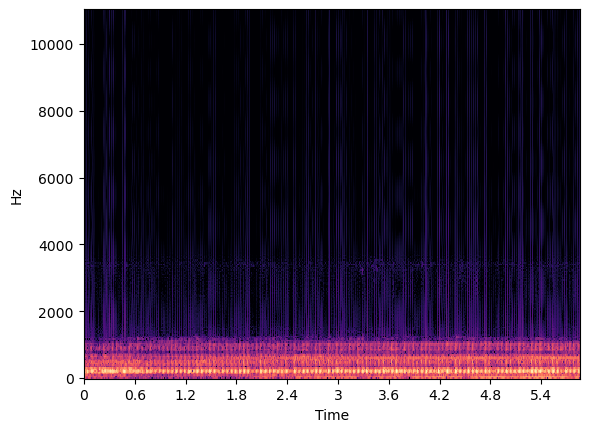

In [37]:
res_stft = stft_fft(xn,window_size =500, hopsize = int(500/4))
ld.specshow(librosa.amplitude_to_db(np.abs(res_stft.T),ref=np.max), hop_length=int(500/4),y_axis='linear', x_axis='time')
plt.savefig('stft_fft.png')

# CALCULATE MEL SPECTROGRAM

MEL spectrogram shape:  (128, 563)


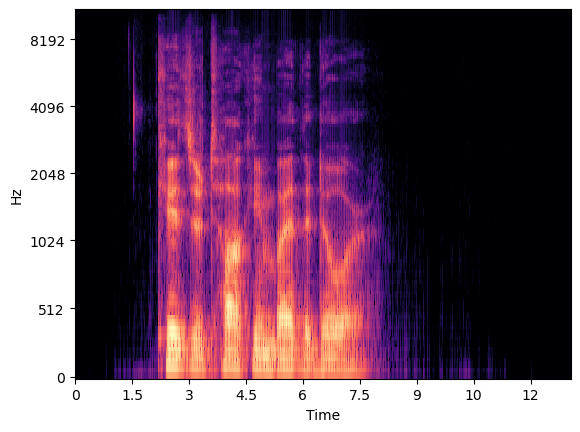

In [38]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

calculate mel spectrograms for all audio files (this can take few minutes to execute)

In [39]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    mel_spectrogram = getMELspectrogram(signal, sample_rate=SAMPLE_RATE)
    mel_spectrograms.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,len(data)),end='')

 Processed 1799/1800 files

augment signals (by adding AWGN) and calculate mel spectrograms

In [40]:
def addAWGN(signals, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [29]:
for i, signals in enumerate(signals):
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        mel_spectrogram = getMELspectrogram(augmented_signals[j,:], sample_rate=SAMPLE_RATE)
        mel_spectrograms.append(mel_spectrogram)
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,len(signals)),end='')

 Processed 599/144000 files

# CREATE MODEL

In [41]:
import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm
                                     

In [42]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

# TRAINING

In [43]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [44]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

stack data

In [45]:
X = np.stack(mel_spectrograms,axis=0)
X = np.expand_dims(X,1)
print('Shape of data: ',X.shape)

del mel_spectrograms
del signals

Shape of data:  (1800, 1, 128, 563)


split data: (train,val,test) --> (80%,10%,10%) proportionaly for each emotion (class) 

In [46]:
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:,:,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:,:,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:,:,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(1440, 1, 128, 563), Y_train:(1440,)
X_val:(180, 1, 128, 563), Y_val:(180,)
X_test:(180, 1, 128, 563), Y_test:(180,)
Number of unique indexes is 1800, out of 1800


scale data

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

b,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h,w))

b,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,c,h,w))

b,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,c,h,w))

Train the model

In [50]:
EPOCHS=3
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")
    

Selected device is cpu
Number of trainable params:  263593
 Epoch 0: iteration 11/45

KeyboardInterrupt: 

# Save model

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt')))

# Load model

In [51]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = ParallelModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))

Model is loaded from C:\Users\mahan\Desktop\Code\models\cnn_lstm_parallel_model.pt


# Test

In [52]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 2.074
Test accuracy is 17.22%


confusion matrix

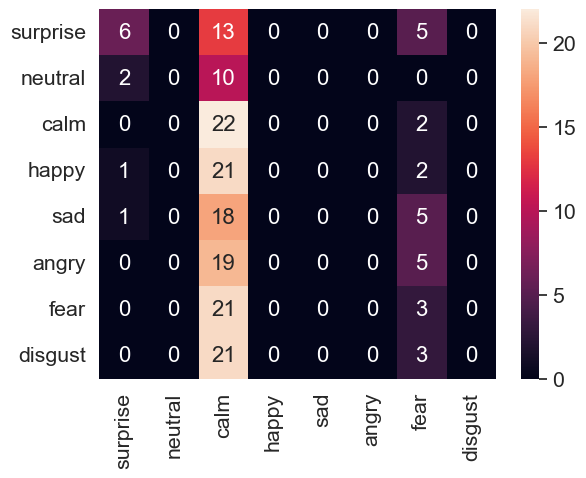

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between emotion intensity and corectness

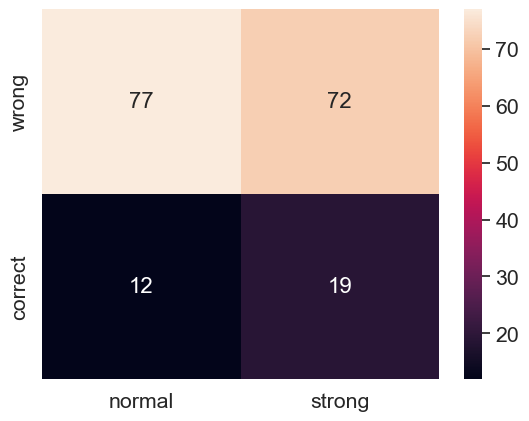

In [54]:
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between gender and corectness

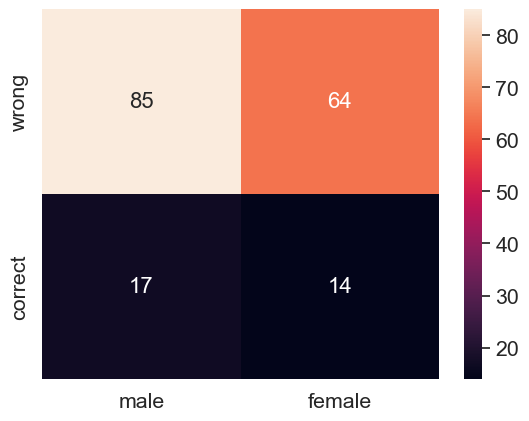

In [55]:
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

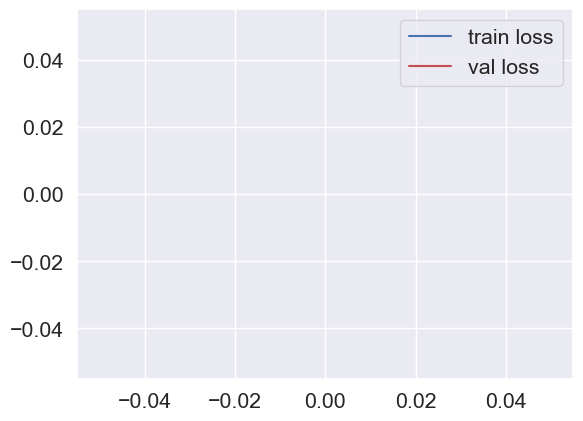

In [56]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])

In [57]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()

NameError: name 'model_history' is not defined